In [1]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tabulate import tabulate

# A Quantum Algorithm for Solving Linear Differential Equations: Theory and Experiment
This notebook follows the paper [A Quantum Algorithm for Solving Linear Differential Equations: Theory and Experiment (arXiv:1807.04553)](https://arxiv.org/pdf/1807.04553). The below experiment is only for the case when the matrix is unitary, for the non-unitary case refer the supplementary matterial at the end of the paper.
## Problem
An unknown vector $x(t)$ starts from an initial point $x(0)$ and follows an evolution described by the linear differential equation:

$$
\frac{dx(t)}{dt} = M x(t) + b
$$

where:  

- $M$ is an arbitrary $N \times N$ matrix  
- $b$ is an $N$-dimensional vector  
- $x(t)$ is an $N$-dimensional vector

The analytical solution of the equation can be written as:

$$
x(t) = e^{Mt} x(0) + (e^{Mt} - I) M^{-1} b.
$$

If the exponential evolution $e^{Mt}$ and the inverse operator $M^{-1}$ can be effectively realized, one can easily obtain the solution $x(t)$. In the following, we present the basic idea of finding $x(t)$ based on a quantum algorithm. By Taylor expansion, the solution $x(t)$ is approximately:

$$
x(t) \approx \sum_{m=0}^{k} \frac{(M t)^m}{m!} x(0) + \sum_{n=1}^{k} \frac{M^{n-1} t^n}{n!} b, 
$$

where $k$ is the approximation order.



## Quantum Representation of Vectors and Matrix

Vectors $x(0)$ and $b$ can be described by quantum states:

$$
|x(0)\rangle = \sum_{j} \frac{x_j (0)}{\|x(0)\|} |j\rangle
$$

and  

$$
|b\rangle = \sum_{j} \frac{b_j}{\|b\|} |j\rangle,
$$

respectively, where $x_j (0)$ and $b_j$ are the $j$-th elements of these vectors, $|j\rangle$ is the $N$-dimensional computational basis, and $\|\cdot\|$ is the module operation.  

Matrix $M$ can be described by operator $A$ defined as:

$$
A = \sum_{i,j} \frac{M_{ij}}{\|M\|} |i\rangle \langle j|.
$$

This normalizes the matrix.

Hence, the k-th order approximate solution converts to 
 
$$
|x(t)\rangle \approx \sum_{m=0}^{k} \frac{\|x(0)\| (\|M\| A t)^m}{m!} |x(0)\rangle + \sum_{n=1}^{k} \frac{\|b\| (\|M\| A)^{n-1} t^n}{n!} |b\rangle  \qquad\qquad\qquad(1)
$$

## If A is Unitary 

If operator $A$ is unitary, the powers of $A$ will also be unitary. Let:

- $U_m = A^m$,  
- $U_n = A^n$,  
- $C_m = \frac{\|x(0)\| (\|M\| t)^m}{m!}$,  
- $D_n = \frac{\|b\| (\|M\| t)^{n-1} t}{n!}$.  

By substituting them into Eq. $(1)$, 

$$
|x(t)\rangle \approx \frac{1}{N_2} \left( \sum_{m=0}^{k} C_m U_m |x(0)\rangle + \sum_{n=1}^{k} D_n U_{n-1} |b\rangle \right)
$$

where $N^2 = C^2 + D^2$ with:

$$
C = \sqrt{\sum C_m}, \quad D = \sqrt{\sum D_n}
$$

as the normalization factor. Thus, the $j$-th element of $x(t)$ would be:

$$
x_j (t) = N^2 \langle j | x(t) \rangle.
$$


## Solving the differential equation of the harmonic oscillator:

$$ y'' + \omega^2 y = 0, \quad y(0) = 1, \quad y'(0) = 1 $$

with $\omega = 1$.

This equation can be rewritten as a first-order system:

$$ x(t) =
\begin{bmatrix}
y \\
y'
\end{bmatrix}. $$

$$ \frac{dx}{dt} =
\begin{bmatrix}
0 & 1 \\
- \omega^2 & 0
\end{bmatrix} x. $$

- **Kinetic Energy (KE):**  
  $$
  KE = \frac{1}{2} (y')^2
  $$

- **Potential Energy (PE):**  
  $$
  PE = \frac{1}{2} y^2
  $$

### For harmonic oscillator,

Since the matrix M for harmonic oscillator is already normalized and unitary, we then have $A = M$

$$
|x(t)\rangle \approx \sum_{m=0}^{k} \frac{\|x(0)\| (At)^m}{m!} |x(0)\rangle + \sum_{n=1}^{k} \frac{\|b\| (A)^{n-1} t^n}{n!} |b\rangle.
$$

we get,
- $C_m = \frac{\|x(0)\| (t)^m}{m!}$,  
- $D_n = \frac{\|b\| (t)^{n-1} t}{n!}$,
- $U_m = A^m$

Since $A$ is now Unitary we can solve this equation using the circuit described.



we have,
$$ A = M =
\begin{bmatrix}
0 & 1 \\
-1 & 0
\end{bmatrix}, b = \begin{bmatrix}
0 \\
0
\end{bmatrix}, x(0) = \begin{bmatrix}
1 \\
1
\end{bmatrix} $$



In [2]:
# Inputs 
n = 2                                   
t = 1                                    
M = np.array([[0, 1], [-1, 0]])         
x_0 = [1, 1]                            
b = [0, 0]
#constants
k = 7
x_0_norm = np.linalg.norm(x_0)
b_norm = np.linalg.norm(b)
M_norm = np.linalg.norm(M)
T = int(np.log2(k + 1))
dim = int(np.log2(n))
# A = np.multiply(1/np.linalg.norm(M), M) 
A = M
v = []
vs1 = []
vs2 = []
c = 0
d = 0
N = 0

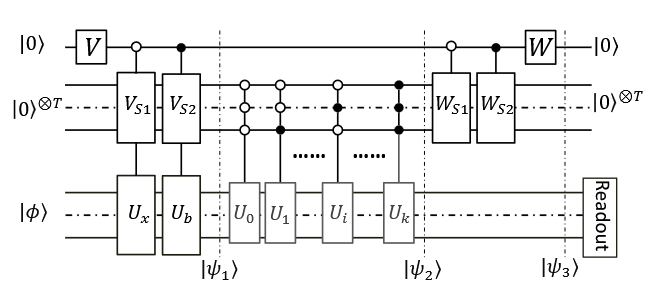
### (i) Encoding

The first operator $V$ is defined as:

$$
V = \frac{1}{N}
\begin{bmatrix}
C & D \\
D & -C
\end{bmatrix}.
$$

This operation puts the first ancilla qubit into superposition.


With the first qubit as control the ancilla register $|0\rangle^{⊗T}$, where $T = log_{2}(k+1)$, and the input register $|𝜙\rangle$ are evolved as:

$$
|0\rangle \sum_{m=0}^{k} \sqrt{C_m} |m\rangle + |1\rangle \sum_{n=1}^{k} \sqrt{D_n} |n\rangle.
$$

and,

$$
|0\rangle |x(0)\rangle + |1\rangle |b\rangle.
$$

After computation, the system evolves into:

$$
|\psi_1\rangle = \frac{1}{N}
\left( |0\rangle \sum_{m=0}^{k} \sqrt{C_m} |m\rangle |x(0)\rangle 
+ |1\rangle \sum_{n=1}^{k} \sqrt{D_n} |n - 1\rangle |b\rangle \right).
$$

### Calculating Matrix $ V_{S1} $

$$
V_{S1} = \frac{1}{C}
\begin{bmatrix}
\sqrt{C_0} & Q & Q & Q & Q & Q \\
\sqrt{C_1} & Q & Q & Q & Q & Q \\
\vdots & Q & Q & Q & Q & Q \\
\sqrt{C_k} & Q & Q & Q & Q & Q
\end{bmatrix}_{(k+1) \times (k+1)}
$$

Where $Q$ s are arbitary values that make the matrix Unitary 


In [3]:
def VS1():
    global vs1
    global c
    vs1 = []
    c = 0
    c_m = np.zeros(k + 1)
    m_factorial = 1
    for i in range(k + 1):
        c_m[i] = (x_0_norm * (pow(t, i))) / m_factorial
        # c_m[i] = (x_0_norm * (pow(t * M_Norm, i))) / m_factorial
        c += c_m[i]
        m_factorial *= (i + 1)

    c = np.sqrt(c)

    if(t == 0):
        vs1 = np.eye(k + 1, k + 1)
        return

    # Construct Unitary matrix with the first column as defined above in the markdown
    e = np.zeros(k + 1)
    e[0] = 1
    w = np.subtract([np.sqrt(c_m[i]) / c for i in range(k + 1)], e)    
    vs1 = np.subtract(np.identity(k + 1), np.multiply(2 * (1 / np.inner(w, w)), np.outer(w, w)))


### Calculating Matrix $ V_{S2} $
$$
V_{S2} = \frac{1}{D}
\begin{bmatrix}
\sqrt{D_1} & Q & Q & Q & Q & Q \\
\sqrt{D_2} & Q & Q & Q & Q & Q \\
\vdots & Q & Q & Q & Q & Q \\
\sqrt{D_k} & Q & Q & Q & Q & Q \\
0 & Q & Q & Q & Q & Q
\end{bmatrix}_{(k+1) \times (k+1)}
$$
Where $Q$ s are arbitary values that make the matrix Unitary 

In [4]:
def VS2():
    
    global vs2
    global d
    vs2 = []
    d = 0
    d_m = np.zeros(k + 1)
    n_factorial = 1
    for i in range(1, k + 1):
        d_m[i - 1] = (b_norm * (pow(t * M_norm, i - 1))) / n_factorial
        d += d_m[i - 1]
        n_factorial *= (i + 1)
    d_m[k] = 0
    d = np.sqrt(d)

    if(d == 0):
        vs2 = np.eye(k + 1, k + 1)
        return
    # Construct Unitary matrix with the first column as defined above in the markdown
    e = np.zeros(k + 1)
    e[0] = 1
    w = np.subtract([np.sqrt(d_m[i]) / d for i in range(k + 1)], e)        
    vs2 = np.subtract(np.identity(k + 1), np.multiply(2 * (1 / np.inner(w, w)), np.outer(w, w)))

### Calculating Matrix  $V$ 
$$
V = \frac{1}{N}
\begin{bmatrix}
C & D \\
D & -C
\end{bmatrix}.
$$

Since $ D = 0 $, 
$$
N = C,  
$$
$$
V = \begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}.
$$


In [5]:
def V():
    global v
    global N
    v = []
    N = np.sqrt(c * c + d * d)
    if(N==0):
        v = np.eye(2, 2)
    v.append([c / N, d / N])
    v.append([d / N, -c / N])
    v = np.array(v)




The vectors $ |x(0)\rangle $ and $ |b\rangle $ are encoded into the circuit using `inplace_prepare_amplitudes()`.

The offset vector $ |b\rangle $ is a zero vector and it will not be applied.

The resulting state is, 

$$
|\psi_1\rangle = \frac{1}{C}
\left( |0\rangle \sum_{m=0}^{k} \sqrt{C_m} |m\rangle |x(0)\rangle\right).
$$

Here $ |x(0)\rangle $ vector is encoded into qubit register `x` ,
    
`y` acts as the control qubit

In [6]:
@qfunc
def encoding(x : QNum, ancilla: QNum, y : QBit):
    prob_x_0 = []
    for i in x_0:
        prob_x_0.append(i / x_0_norm)
    inplace_prepare_amplitudes(prob_x_0, 0.01, x)
    prob_b = []
    # for i in b:
    #     prob.append(i / b_norm)
  
    VS1()
    VS2()
    V()
    
    unitary(v, y)
    control(y == 0, lambda : unitary(vs1, ancilla), lambda : unitary(vs2, ancilla))
    # control(y == 0, lambda : inplace_prepare_state(prob_x_0, 0.01, x), lambda : inplace_prepare_state(prob_b, 0.01, x))


### Step 2 : Evolution

The unitary matrix $ U_m $ is conditionally applied depending on the value in `ancilla` register 

The resulting state is,

$$
|\psi_2\rangle = \frac{1}{C}
\left( |0\rangle \sum_{m=0}^{k} \sqrt{C_m} |m\rangle U_m |x(0)\rangle\right).
$$


In [7]:
@qfunc
def evolution(x: QNum, ancilla:QNum):
     u_m = np.array([[1, 0], [0, 1]])
     for i in range(k + 1):
          control(ancilla == i, lambda: unitary(u_m, x)) 
          u_m = u_m @ A


### Step 3 : Decoding

The steps applied in Encoding are reversibly applied. The resulting state in the subspace where all the work qubits are $|0\rangle$ is,

$$
|\psi_3\rangle = \frac{1}{C^2} |0\rangle |0\rangle^{\otimes T} 
\left(\sum_{m=0}^{k} C_mU_m |x(0)\rangle\right).
$$

In [8]:
@qfunc
def decoding(ancilla:QNum, y : QBit):
    ws1 = vs1.T
    ws2 = vs2.T
    w = v.T
    control(y == 0, lambda : unitary(ws1, ancilla), lambda : unitary(ws2, ancilla))
    unitary(w, y)

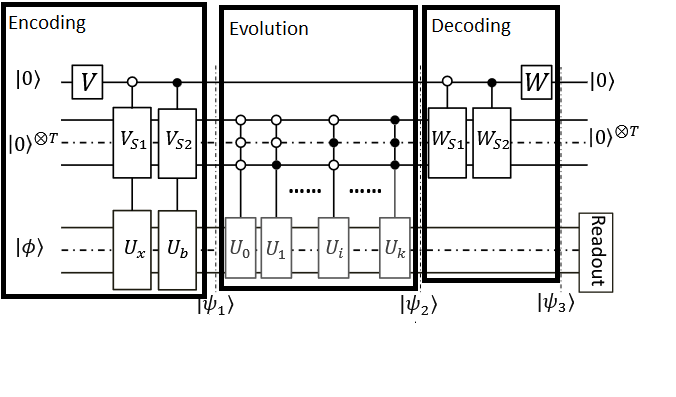

In classiq the circuit is reversed to factor in endianness

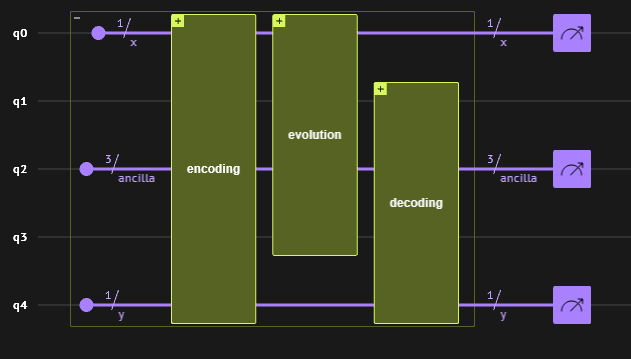



In [9]:
@qfunc
def main(x : Output[QNum[dim]], ancilla : Output[QNum[T]], y : Output[QBit] ):
    allocate(x)
    allocate(ancilla)
    allocate(y)
    
    encoding(x, ancilla, y)
    evolution(x, ancilla)
    decoding(ancilla, y)

In [10]:
execution_preferences = ExecutionPreferences(
    num_shots=1000,
    backend_preferences = ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    )
)  

### Step 4 : Measurement

The magnitude of the states where the work qubits are $|0\rangle$ is extracted.

$$
x_j (t) = N^{2} * magnitude_j.
$$

Thus, the solution to the LDE is obtained up to a factor $N^{2}$.

In [11]:
create_model(main, out_file="harmonic_oscillator")

'{\n  "source_ref": null,\n  "back_ref": null,\n  "version": "0.75.0",\n  "interface_version": "10",\n  "kind": "user",\n  "functions": [\n    {\n      "source_ref": null,\n      "back_ref": null,\n      "name": "encoding",\n      "positional_arg_declarations": [\n        {\n          "source_ref": null,\n          "back_ref": null,\n          "name": "x",\n          "quantum_type": {\n            "source_ref": null,\n            "back_ref": null,\n            "kind": "qnum",\n            "size": null,\n            "is_signed": null,\n            "fraction_digits": null\n          },\n          "direction": "inout",\n          "type_qualifier": "quantum",\n          "kind": "PortDeclaration"\n        },\n        {\n          "source_ref": null,\n          "back_ref": null,\n          "name": "ancilla",\n          "quantum_type": {\n            "source_ref": null,\n            "back_ref": null,\n            "kind": "qnum",\n            "size": null,\n            "is_signed": null,\n    

In [12]:
global t 
y = []
y_dash = []
t_range = 10
for i in range(t_range + 1):
    t = i / 10
    print(t)
    qmod = create_model(main)
    qmod = set_execution_preferences(qmod, execution_preferences)
    qprog = synthesize(qmod)
    job = execute(qprog)
    results = job.result()
    results = job.result_value()
    for i in results.parsed_state_vector:
        if( int(i.bitstring[:-dim], 2) == 0):
            print(i.bitstring," : ",np.linalg.norm(i.amplitude) * (N * N))
            if(int(i.bitstring, 2) == 0):
                y.append(np.linalg.norm(i.amplitude) * (N * N))
            if(int(i.bitstring, 2) == 1):
                y_dash.append(np.linalg.norm(i.amplitude) * (N * N))
            

0.0
00000  :  1.000000000000007
00001  :  0.9999999999999902
0.1
00000  :  1.0948375819246137
00001  :  0.8951707486309246
0.2
00000  :  1.1787359085714408
00001  :  0.7813972469841685
0.3
00000  :  1.2508566941071517
00001  :  0.6598162808928442
0.4
00000  :  1.310479319365082
00001  :  0.5316426361904453
0.5
00000  :  1.357007998511918
00001  :  0.39815693204366487
0.6
00000  :  1.3899776457143005
00001  :  0.26069275428570865
0.7
00000  :  1.4090583418055609
00001  :  0.12062318875000463
0.8
00000  :  1.414058300952367
00001  :  0.020653145396851993
0.9
00000  :  1.404925237321421
00001  :  0.16172646232148238
1.0
00000  :  1.3817460317460035
00001  :  0.30119047619055866


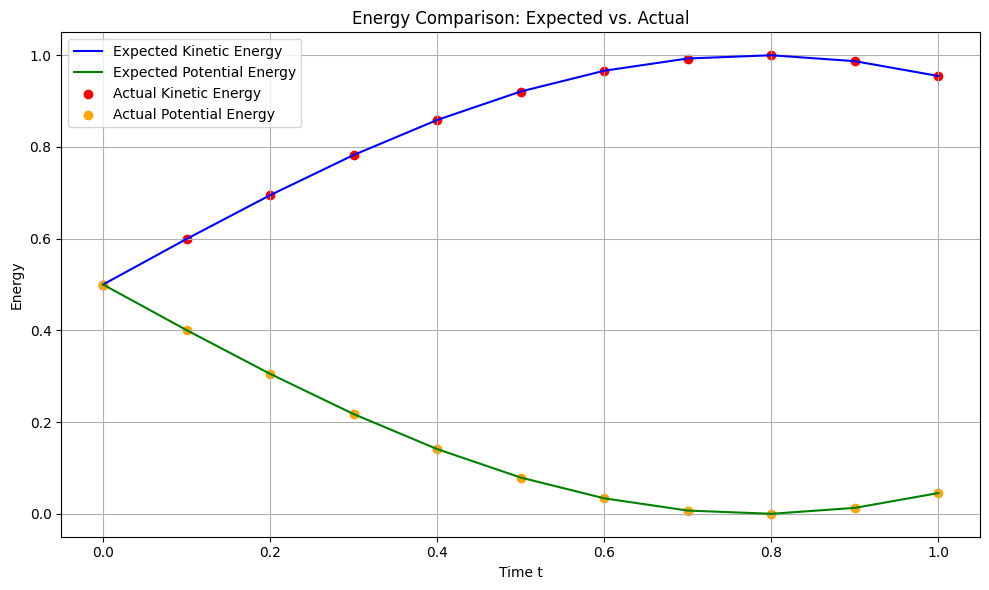

In [13]:
t_values = [i/10 for i in range(t_range + 1)]


# Expected energies calculated from the formulas
y_values = [np.sin(t) + np.cos(t) for t in t_values]
ydash_values = [np.cos(t) - np.sin(t) for t in t_values]

kinetic_expected = [(y ** 2) / 2 for y in y_values]
potential_expected = [(ydash ** 2) / 2 for ydash in ydash_values]


# Actual energies calculated from algorithm outputs:
kinetic_actual = [(y_val ** 2) / 2 for y_val in y]            
potential_actual = [(ydash_val ** 2) / 2 for ydash_val in y_dash]


plt.figure(figsize=(10, 6))


plt.plot(t_values, kinetic_expected, label="Expected Kinetic Energy", color="blue", linestyle="-")
plt.plot(t_values, potential_expected, label="Expected Potential Energy", color="green", linestyle="-")


plt.scatter(t_values, kinetic_actual, label="Actual Kinetic Energy", color="red", marker="o")
plt.scatter(t_values, potential_actual, label="Actual Potential Energy", color="orange", marker="o")


plt.xlabel("Time t")
plt.ylabel("Energy")
plt.title("Energy Comparison: Expected vs. Actual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
results = [ [t/10, kinetic_expected[t], kinetic_actual[t], potential_expected[t], potential_actual[t]] for t in range(t_range+1)]
table = tabulate(results, headers=["t", "Kinetic expected","Kinetic actual", "Potential expected", "Potential actual)"], numalign="center", tablefmt="github")
print(table)

error_bound_potential = [100*np.abs(a-e)/a for a, e in zip(potential_expected, potential_actual)]
error_bound_kinetic = [100*np.abs(a-e)/a for a, e in zip(kinetic_expected, kinetic_actual)]

print("\n\nkinetic accuracy (Mean): ", 100-np.mean(error_bound_kinetic), "%")
print("potential accuracy (Mean): ", 100-np.mean(error_bound_potential), "%")

|  t  |  Kinetic expected  |  Kinetic actual  |  Potential expected  |  Potential actual)  |
|-----|--------------------|------------------|----------------------|---------------------|
|  0  |        0.5         |       0.5        |         0.5          |         0.5         |
| 0.1 |      0.599335      |     0.599335     |       0.400665       |      0.400665       |
| 0.2 |      0.694709      |     0.694709     |       0.305291       |      0.305291       |
| 0.3 |      0.782321      |     0.782321     |       0.217679       |      0.217679       |
| 0.4 |      0.858678      |     0.858678     |       0.141322       |      0.141322       |
| 0.5 |      0.920735      |     0.920735     |      0.0792645       |      0.0792645      |
| 0.6 |      0.96602       |     0.966019     |      0.0339805       |      0.0339804      |
| 0.7 |      0.992725      |     0.992723     |      0.00727514      |     0.00727498      |
| 0.8 |      0.999787      |     0.99978      |     0.000213198      |